# Classification of CIFAR 10 Image Dataset

### Starting lines and necessary imports

In [0]:
from torchsummary import summary
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


%load_ext autoreload
%autoreload 2

Run the two cells below if using Google Colab (you need to have a folder called AdvMachineLearningProject with the files in it)

In [2]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [3]:
cd /drive/My\ Drive/AdvMachineLearningProject

/drive/My Drive/AdvMachineLearningProject


## Load CIFAR 10 Data using torchvision

### Data Pre-processing (Mean, Standard Deviation and Transforms)

In [4]:
# Data Sets without any processing
train_dataset_raw = datasets.CIFAR10('CIFAR10',
                                     train=True,
                                     download=True,
                                     transform=transforms.ToTensor())
test_dataset_raw = datasets.CIFAR10('CIFAR10',
                                    train=False,
                                    download=True,
                                    transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def calculate_mean(loader):
    images, labels = iter(loader).next()
    mean = images.sum(dim=(0, 2, 3), keepdim=True)
    mean = mean/images.shape[0]/images.size(2)/images.size(3)
    return mean

In [0]:
def calculate_std(loader, mean):
    images, labels = iter(loader).next()
    std = (images - mean).pow(2).sum(dim=(0, 2, 3), keepdim=True)
    std = torch.sqrt(std/(images.shape[0]*images.size(2)*images.size(3)-1))
    return std

In [0]:
def mean_and_stddev():
    train_loader = torch.utils.data.DataLoader(train_dataset_raw,
                                               batch_size=50000,
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset_raw,
                                              batch_size=10000,
                                              shuffle=True)

    tr_mean = calculate_mean(train_loader)
    tst_mean = calculate_mean(test_loader)
    tr_std = calculate_std(train_loader, tr_mean)
    tst_std = calculate_std(test_loader, tst_mean)

    return tr_mean.view(-1), tst_mean.view(-1), tr_std.view(-1), tst_std.view(-1)

#### Mean and Standard Deviation for Training and Test Datasets

In [8]:
tr_mean, tst_mean, tr_std, tst_std = mean_and_stddev()
print(tr_mean)
print(tst_mean)
print(tr_std)
print(tst_std)

tensor([0.4914, 0.4822, 0.4465])
tensor([0.4942, 0.4851, 0.4504])
tensor([0.2470, 0.2435, 0.2616])
tensor([0.2467, 0.2429, 0.2616])


#### Transformations

In [0]:
# Transformations on training set
# Crop, Horizontal Flip, Tensor, Normalize (3 channels)
transform_tr = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(tr_mean, tr_std)
])

# Transformations on testing set
# Tensor and Normalize (3 channels)
transform_tst = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(tst_mean, tst_std)
])

### Load Training and Testing Data

In [10]:
# Batch Size Hyperparameters
train_batch_size = 32
val_batch_size = 5000  # representing a 90/10 train/validation split
test_batch_size = 5000  # smaller test batches due to memory constraints

# to randomly shuffle data
indices = np.arange(50000)
np.random.shuffle(indices)

# samplers to split into training and validation set
tr_sampler = torch.utils.data.SubsetRandomSampler(indices[:45000])
val_sampler = torch.utils.data.SubsetRandomSampler(indices[45000:50000])


# CIFAR-10 training dataset and data loader
train_dataset = datasets.CIFAR10('CIFAR10',
                                 train=True,
                                 download=True,
                                 transform=transform_tr)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=False,
                                           sampler=tr_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=val_batch_size,
                                         shuffle=False,
                                         sampler=val_sampler)

# CIFAR-10 test dataset and data loader
test_dataset = datasets.CIFAR10('CIFAR10',
                                train=False,
                                download=True,
                                transform=transform_tst)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=test_batch_size,
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


#### Check batches and image/label shapes

In [11]:
# check num of batches in each training epoch (should be 45,000/train_batch_size)
print(len(train_loader))
# check num of batches in each training epoch (should be 5,000/val_batch_size = 1)
print(len(val_loader))
# check num of batches in each test epoch (should be 10,000/test_batch_size)
print(len(test_loader))
# check shape
images, labels = iter(train_loader).next()
print(images.shape)  # shape = (train_batch_size, RGB channels, H, W)
print(labels.shape)  # shape = (train_batch_size)

1407
1
2
torch.Size([32, 3, 32, 32])
torch.Size([32])


#### Function to show individual image and associated label

In [0]:
def show_images():
    train_loader = torch.utils.data.DataLoader(train_dataset_raw,
                                               batch_size=1,
                                               shuffle=True)

    fig = plt.figure(figsize=(32, 32))
    columns = 5
    rows = 4

    ax = []
    plt.rcParams.update({'font.size': 22})
    for i in range(1, columns * rows + 1):
        image, label = iter(train_loader).next()
        ax.append(fig.add_subplot(rows, columns, i))
        ax[-1].set_title(
            str(label.item()) + " - " +
            str(train_loader.dataset.classes[label]))
        plt.imshow(np.transpose(image[0], (1, 2, 0)))
    plt.show()
    plt.rcParams.update({'font.size': 12})

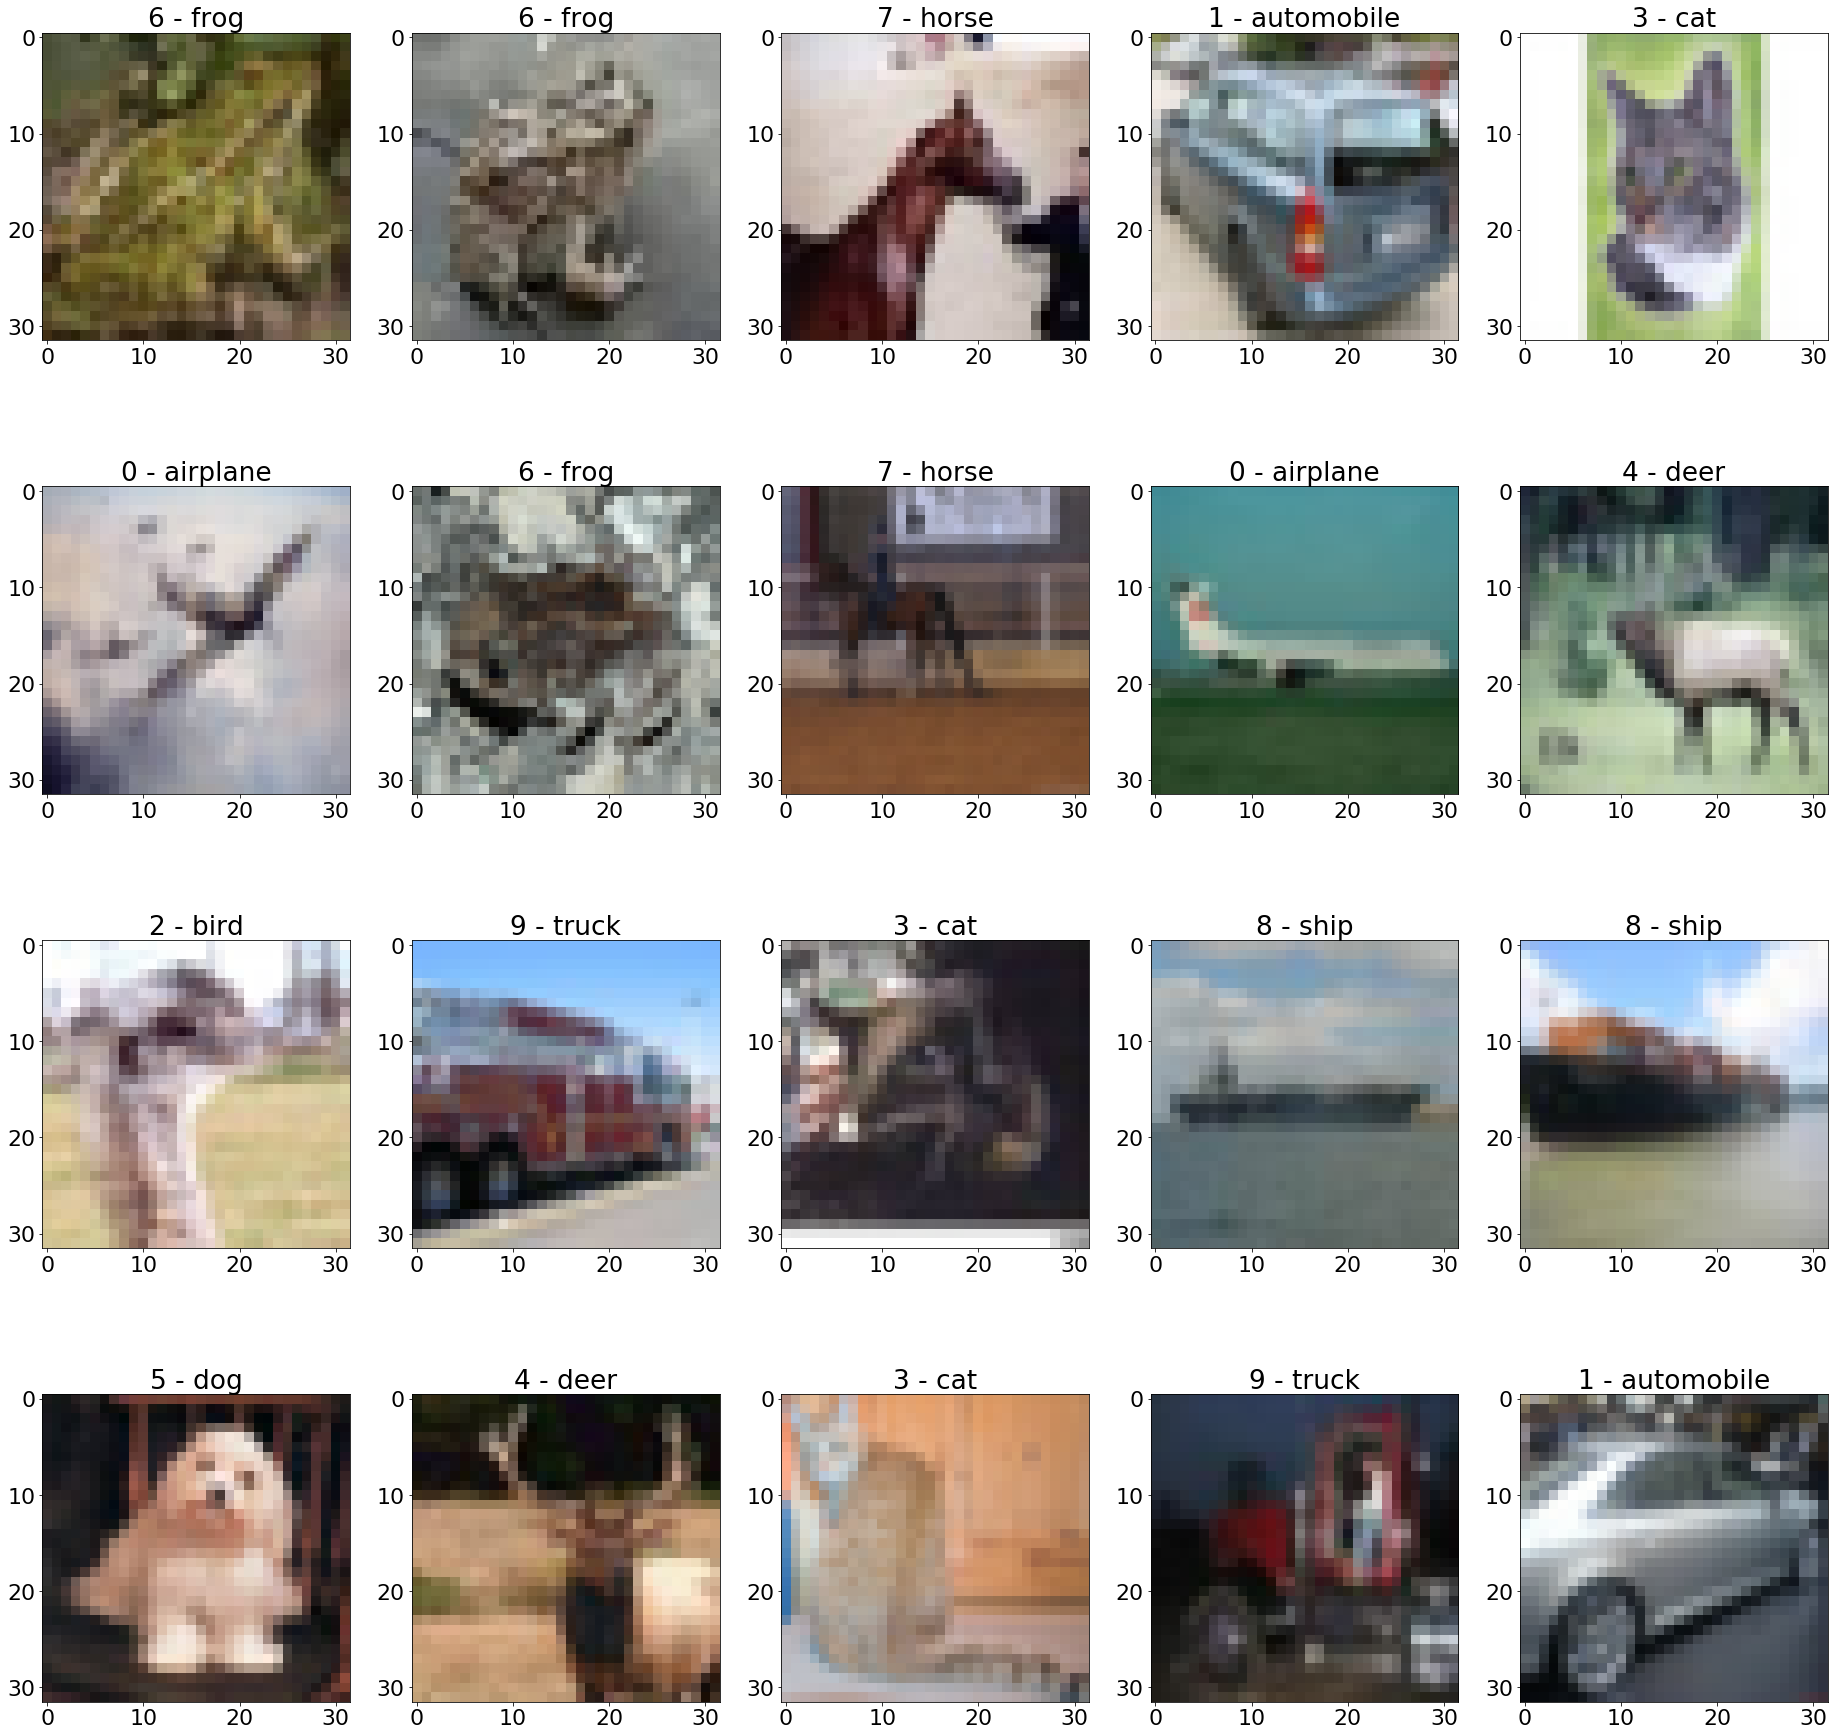

In [13]:
show_images()

# Helper functions for Neural Network

In [0]:
def accuracy(outputs, labels):
    """Function for determining the accuracy of a set of model outputs compared to label values."""
    prediction = outputs.cpu().max(1, keepdim=True)[1].squeeze()
    prediction_comp = torch.eq(prediction.cpu(), labels.cpu())
    prediction_comp = prediction_comp.sum().numpy() / torch.numel(prediction.cpu())
    return prediction_comp * 100

In [0]:
def cpu_or_gpu():
    """Function to determine whether to train using a GPU or CPU."""
    train_on_gpu = torch.cuda.is_available()
    if not train_on_gpu:
        device = torch.device('cpu')
    else:
        device = torch.device('cuda:0')
    return device

In [0]:
def reduce_step_size(iteration_cutoff, old_step_size, new_step_size, epoch):
    """Used in training to reduce step size"""
    step_size = old_step_size
    if epoch == iteration_cutoff:
        step_size = new_step_size
        if epoch == iteration_cutoff:
            print(
                "Log -- Decreased Step size from {} to {}".format(old_step_size, new_step_size))
    return step_size

# Initialize settings for Neural Network

## Main Model

In [0]:
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()

        # 5 Convolutional Layers
        # 100 - 3x3, 200 - 2x2, 300 - 2x2, 400 - 2x2, 500 - 2x2
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.conv2 = nn.Conv2d(100, 200, 2, padding=1)
        self.conv3 = nn.Conv2d(200, 300, 2, padding=1)
        self.conv4 = nn.Conv2d(300, 400, 2, padding=1)
        self.conv5 = nn.Conv2d(400, 500, 2, padding=1)

        # Dropout Layer (p=0.5)
        self.drop = nn.Dropout2d()

        # Max Pooling Layer (2 x 2)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Output Layer
        self.fc1 = nn.Linear(4500, 10)

        # Activation function
        self.activ1 = nn.ReLU()

    def forward(self, x):
        # 5 convolutional / pooling layers
        x = self.activ1(self.conv1(x))
        x = self.pool(x)
        x = self.activ1(self.conv2(x))
        x = self.pool(x)
        x = self.activ1(self.conv3(x))
        x = self.pool(x)
        x = self.activ1(self.conv4(x))
        x = self.pool(x)
        x = self.activ1(self.conv5(x))
        x = self.drop(x)

        # Final Output Layer
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)

        return x

## Other attempts

class Neural_Network_batch_norm(nn.Module):
    def __init__(self):
        super(Neural_Network2, self).__init__()

        # 5 Convolutional Layers
        # 100 - 3x3, 200 - 2x2, 300 - 2x2, 400 - 2x2, 500 - 2x2
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.conv2 = nn.Conv2d(100, 200, 2, padding=1)
        self.conv3 = nn.Conv2d(200, 300, 2, padding=1)
        self.conv4 = nn.Conv2d(300, 400, 2, padding=1)
        self.conv5 = nn.Conv2d(400, 500, 2, padding=1)

        # Max Pooling Layer (2 x 2)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(100)
        self.bn2 = nn.BatchNorm2d(200)
        self.bn3 = nn.BatchNorm2d(300)
        self.bn4 = nn.BatchNorm2d(400)
        self.bn5 = nn.BatchNorm2d(500)

        # Fully Connected Output Layer
        self.fc1 = nn.Linear(4500, 100)

        # Activation function
        self.activ1 = nn.ReLU(inplace=True)

    def forward(self, x):
        # 5 convolutional / pooling layers
        x = self.activ1(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.activ1(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        x = self.activ1(self.bn3(self.conv3(x)))
        x = self.maxpool(x)
        x = self.activ1(self.bn4(self.conv4(x)))
        x = self.maxpool(x)
        x = self.activ1(self.bn5(self.conv5(x)))

        # Final Output Layer
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)

        return x

class Neural_Network_3(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        # Convolutional Layer -
        self.conv1 = nn.Conv2d(3, 6, 5, padding=1)

        # 2nd Convolutional Layer -
        self.conv2 = nn.Conv2d(6, 16, 5, padding=1)

        # 3rd Convolutional Layer -
        self.conv3 = nn.Conv2d(16, 32, 5, padding=1)

        # Max Pooling layers -
        self.pool = nn.MaxPool2d(2, 2)

        # 3 fully connected layers
        self.fc1 = nn.Linear(2048, 250)
        self.fc2 = nn.Linear(250, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)

        #Dropout for regularization using default p=0.5
        #self.dr1 = nn.Dropout2d()
        self.dr2 = nn.Dropout()

        # Activation function
        self.activ1 = nn.ReLU()
        #self.activ1 = nn.Tanh()
        #self.activ2 = nn.LocalResponseNorm(2)

    def forward(self, x):
        # 2 convolutional / pooling layers
        x = self.activ1(self.conv1(x))
        x = self.activ1(self.conv2(x))
        x = self.pool(x)
        x = self.activ1(self.conv3(x))

        # 2 fully connected hidden layers
        x = x.view(x.shape[0], -1)
        x = self.activ1(self.fc1(x))
        x = self.dr2(x)
        x = self.activ1(self.fc2(x))
        x = self.dr2(x)
        x = self.activ1(self.fc3(x))
        x = self.dr2(x)

        # final output layer
        x = self.fc4(x)

        return x

class Neural_Network2(nn.Module):
    def __init__(self):
        super(Neural_Network2, self).__init__()
        # Convolutional Layer - 
        self.conv1 = nn.Conv2d(3,6,3)
        
        # 2nd Convolutional Layer -
        self.conv2 = nn.Conv2d(6,6,5)
        
        # 3rd Convolutional Layer -
        self.conv3 = nn.Conv2d(6,8,5)
        
        # 4th Convolutional Layer
        self.conv4 = nn.Conv2d(8,10,5)
        
        # Max Pooling layers - 
        self.pool = nn.MaxPool2d(2,2)
             
        # 3 fully connected layers
        self.fc1 = nn.Linear(40, 10)
        
        # Activation function
        self.activ1 = nn.ReLU()
        
    def forward(self, x):
        # 2 convolutional / pooling layers
        x = self.activ1(self.conv1(x))
        x = self.activ1(self.conv2(x))
        x = self.pool(x)
        x = self.activ1(self.conv3(x))
        x = self.activ1(self.conv4(x))
        x = self.pool(x)
        
        # 2 fully connected hidden layers
        x = x.view(-1,40)
        x = self.activ1(self.fc1(x))
        
        return x

class Neural_Network_Linear(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.fc1 = nn.Linear(32* 32 * 3, 256)
        self.fc2 = nn.Linear(256,200)
        self.fc3 = nn.Linear(200, 10)
        self.activ = nn.functional.relu
        
    def forward(self, x):
        x = self.activ(self.fc1(x))
        x = self.activ(self.fc2(x))
        x = self.fc3(x)
        
        return x

VGG16 architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv_layer = nn.Sequential(
        
            #1st conv layer block
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #2nd conv layer block
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            #3rd conv layer block
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
            #fully connected layers block
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512,10)
        )
        
            #perform forward
        def forward(self, x):
            #conv layers
            x = self.conv_layer(x)
            #flatten
            x = x.view(x.size(0), -1)
            #fully connected layer
            x = self.fc_layer(x)
            
            return x

# Neural Network Training

## Training new model

In [19]:
# Use this cell if training a new model
model = Neural_Network()
device = cpu_or_gpu()
model.to(device)

Neural_Network(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(100, 200, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(200, 300, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(300, 400, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(400, 500, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (drop): Dropout2d(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4500, out_features=10, bias=True)
  (activ1): ReLU()
)

## Loading previously saved model

In [0]:
# Use this cell if loading a saved model
model = Neural_Network()
device = cpu_or_gpu()
model.to(device)
model.load_state_dict(
    torch.load("finalmodelwithmaxdrop"))
               #Conv-NN-ReLU-88.5testaccuracy"))  # <------- Insert path of saved model as string here

model.eval()

## Model Summary

In [20]:
# Summary of layers, output shape, parameters, and size
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 32, 32]           2,800
              ReLU-2          [-1, 100, 32, 32]               0
         MaxPool2d-3          [-1, 100, 16, 16]               0
            Conv2d-4          [-1, 200, 17, 17]          80,200
              ReLU-5          [-1, 200, 17, 17]               0
         MaxPool2d-6            [-1, 200, 8, 8]               0
            Conv2d-7            [-1, 300, 9, 9]         240,300
              ReLU-8            [-1, 300, 9, 9]               0
         MaxPool2d-9            [-1, 300, 4, 4]               0
           Conv2d-10            [-1, 400, 5, 5]         480,400
             ReLU-11            [-1, 400, 5, 5]               0
        MaxPool2d-12            [-1, 400, 2, 2]               0
           Conv2d-13            [-1, 500, 3, 3]         800,500
             ReLU-14            [-1, 50

## Train function

In [0]:
# Initialize cross entropy loss for use in training/testing
criterion = nn.CrossEntropyLoss()

In [0]:
def train():

    # Initial hyperparameters
    number_of_epochs = 100
    step_size = 0.01
    momentum_parameter = 0.9
    lambda1 = 0.001

    # L2 Regularization
    all_linear1_params = torch.cat(
        [x.view(-1) for x in model.fc1.parameters()])
    l2_regularization = lambda1 * torch.norm(all_linear1_params, 1)

    # Initialize optimiser
    optimiser = optim.SGD(model.parameters(),
                          lr=step_size,
                          momentum=momentum_parameter)

    # initialize lists for running counts of loss and accuracy
    running_loss = []
    running_val_loss = []
    running_training_accuracy = []
    running_training_accuracy.append(0)
    running_val_accuracy = []
    running_val_accuracy.append(0)

    print("Log -- Step size: {}, Momentum: {}, batch_size = {}".format(
        step_size, momentum_parameter, train_batch_size))
    
    # loop for epochs
    for k in range(number_of_epochs):
        model.train()
        device = cpu_or_gpu()
        model.to(device)

        # initialize epoch loss and training accuracy
        epoch_loss = 0
        training_accuracy = 0


        # handle reducing step size at various iterations

        step_size = reduce_step_size(iteration_cutoff=10,
                                     old_step_size=step_size,
                                     new_step_size=0.001,
                                     epoch=k)

        optimiser = optim.SGD(model.parameters(),
                              lr=step_size,
                              momentum=momentum_parameter)

        # Main Training Loop
        for j, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimiser.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)+ (l2_regularization/len(images))
            loss.backward(retain_graph=True)
            optimiser.step()

            epoch_loss += loss.item()
            training_accuracy += accuracy(outputs, labels)

        # Caclulate average loss and accuracy for each epoch
        running_loss.append(epoch_loss / len(train_loader))
        running_training_accuracy.append(training_accuracy / len(train_loader))

        # Validation test once per epoch
        device = torch.device('cpu')
        model.eval()
        model.to(device)
        val_images, val_labels = iter(val_loader).next()
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = model(val_images) + (l2_regularization/len(val_images))
        val_loss = criterion(val_outputs, val_labels).item()

        # Store validation loss and accuracy
        running_val_loss.append(val_loss)
        val_accuracy = accuracy(val_outputs, val_labels)
        running_val_accuracy.append(val_accuracy)
        
        # Running log
        if k % 1 == 0:
            print(
                "Epoch {a}/{b} -> Tr. Loss = {c:.4f}, Val. Loss = {d:.4f}, Tr. Acc = {e:.2f}, Val. Acc = {f:.2f}"
                .format(a=k,
                        b=number_of_epochs,
                        c=running_loss[-1],
                        d=running_val_loss[-1],
                        e=running_training_accuracy[-1],
                        f=running_val_accuracy[-1]))
        
        # Break condition (validation loss is rising)
        """if len(running_val_loss) > 30 and running_val_loss[-1] - running_val_loss[-30] > 0:
            break"""

    print("Final Epoch {} -> Loss = {}".format(k, running_loss[-1]))

    return running_loss, running_val_loss, running_training_accuracy, running_val_accuracy

In [0]:
running_loss, running_val_loss, running_training_accuracy, running_val_accuracy = train()

Log -- Step size: 0.01, Momentum: 0.9, batch_size = 32
Epoch 0/100 -> Tr. Loss = 1.8013, Val. Loss = 1.4113, Tr. Acc = 32.91, Val. Acc = 47.14
Epoch 1/100 -> Tr. Loss = 1.2784, Val. Loss = 1.1189, Tr. Acc = 53.87, Val. Acc = 59.68
Epoch 2/100 -> Tr. Loss = 1.0326, Val. Loss = 0.9406, Tr. Acc = 63.82, Val. Acc = 66.46
Epoch 3/100 -> Tr. Loss = 0.8952, Val. Loss = 0.8236, Tr. Acc = 69.05, Val. Acc = 71.86
Epoch 4/100 -> Tr. Loss = 0.8170, Val. Loss = 0.7422, Tr. Acc = 71.70, Val. Acc = 73.60
Epoch 5/100 -> Tr. Loss = 0.7564, Val. Loss = 0.6893, Tr. Acc = 73.88, Val. Acc = 76.32
Epoch 6/100 -> Tr. Loss = 0.7160, Val. Loss = 0.6596, Tr. Acc = 75.37, Val. Acc = 76.92
Epoch 7/100 -> Tr. Loss = 0.6656, Val. Loss = 0.6725, Tr. Acc = 77.08, Val. Acc = 76.96
Epoch 8/100 -> Tr. Loss = 0.6440, Val. Loss = 0.6436, Tr. Acc = 78.35, Val. Acc = 77.70
Epoch 9/100 -> Tr. Loss = 0.6100, Val. Loss = 0.6351, Tr. Acc = 78.97, Val. Acc = 78.42
Log -- Decreased Step size from 0.01 to 0.001
Epoch 10/100 -> Tr.

### Training Epoch Loss and Accuracy Visualizations

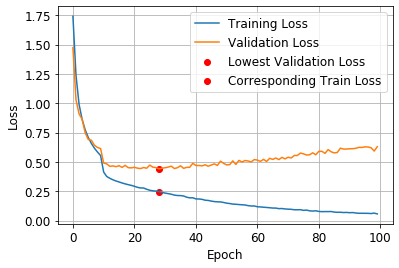

In [0]:
plt.plot(running_loss, label="Training Loss")
plt.plot(running_val_loss, label="Validation Loss")
for i in range(len(running_val_loss)):
    if running_val_loss[i] == np.min(running_val_loss):
        lowest_index = i
plt.scatter(lowest_index,
            running_val_loss[lowest_index],
            label="Lowest Validation Loss",
            c="r")
plt.scatter(lowest_index,
            running_loss[lowest_index],
            label="Corresponding Train Loss",
            c="r")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid()
plt.show()

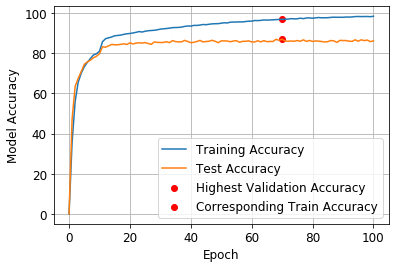

In [0]:
plt.plot(running_training_accuracy, label="Training Accuracy")
plt.plot(running_val_accuracy, label="Test Accuracy")
for i in range(len(running_val_accuracy)):
    if running_val_accuracy[i] == np.max(running_val_accuracy):
        highest_index = i
plt.scatter(highest_index,
            running_val_accuracy[highest_index],
            label="Highest Validation Accuracy",
            c="r")
plt.scatter(highest_index,
            running_training_accuracy[highest_index],
            label="Corresponding Train Accuracy",
            c="r")
plt.legend()
plt.ylabel("Model Accuracy")
plt.xlabel("Epoch")
plt.grid()
plt.show()

# Saving Model State_Dict

In [0]:
# For saving neural network parameters
torch.save(model.state_dict(), 
           "ourmodel96percentaccuracy")  # <----- make sure to update the path if saving new model

# Neural Network Testing

## Test on test dataset

In [0]:
# Accuracy on full test dataset (10,000 test images)
def test_on_testing_data(model):
    """for testing model on test set (10,000 test images), batch size of 1000 
    is used for computational purposes and accuracy/loss are averaged after"""

    criterion = nn.CrossEntropyLoss()  # in case not previously defined

    # initialize network to use CPU
    device = torch.device('cpu')
    model.to(device)
    model.eval()

    # initialize accuracy and loss
    test_accuracy = 0
    epoch_loss = 0

    # loop through test batches and send to CPU
    for j, (test_images, test_labels) in enumerate(test_loader):
        test_images, test_labels = test_images.to(
            device), test_labels.to(device)

        # run images through model to create outputs
        test_outputs = model(test_images)

        # compare outputs to actual labels
        epoch_loss += criterion(test_outputs, test_labels).item()
        test_accuracy += accuracy(test_outputs, test_labels)

    # average over the number of batches
    test_accuracy = test_accuracy / len(test_loader)
    test_loss = epoch_loss / len(test_loader)

    # print results
    print("Test Loss is : {a:.2f}".format(a=test_loss))
    print("Test Accuracy is : {a:.2f}%".format(a=test_accuracy))

In [0]:
test_on_testing_data()

## Test on training dataset

In [0]:
# Accuracy on full train dataset (50,000 training images) without data augmentation
def test_on_training_data(model):
    """for testing model on training batch (50,000 test images), batch size of 1000 
    is used for computational purposes and accuracy/loss are averaged after"""

    criterion = nn.CrossEntropyLoss()  # in case not previously defined

    # initialize network to use CPU
    device = torch.device('cpu')
    model.to(device)
    model.eval()

    # we want to test on data without additional transformations
    transform_tr1 = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])

    # define new train dataset using above transformations
    train_dataset1 = datasets.CIFAR10('CIFAR10',
                                      train=True,
                                      download=True,
                                      transform=transform_tr1)

    # define new loader with batch size and dataset
    train_loader1 = torch.utils.data.DataLoader(train_dataset1,
                                                batch_size=1000,
                                                shuffle=True)
    # initialize accuracy and loss
    test_accuracy = 0  
    epoch_loss = 0

    # loop through test batches and send to CPU
    for j, (test_images, test_labels) in enumerate(train_loader1):
        test_images, test_labels = test_images.to(device), test_labels.to(
            device)

        # run images through model to create outputs
        test_outputs = model(test_images)

        # compare outputs to actual labels
        epoch_loss += criterion(test_outputs, test_labels).item()
        test_accuracy += accuracy(test_outputs, test_labels)

    # average over the number of batches
    test_accuracy = test_accuracy / len(train_loader1)
    test_loss = epoch_loss / len(train_loader1)

    # print results
    print("Training Loss (Full Dataset) is : {a:.2f}".format(a=test_loss))
    print("Training Accuracy (Full Dataset) is : {a:.2f}%".format(
        a=test_accuracy))

In [0]:
test_on_training_data()

Files already downloaded and verified
Training Loss (Full Dataset) is : 0.22
Training Accuracy (Full Dataset) is : 92.35%


# Adversarial Attacks

In [0]:
# define loader with a single image loaded at a time
test_loader1 = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=1,
                                           shuffle=True)

## Define FGSM attack

In [0]:
def fgsm(images, epsilon, images_gradient):
    """given a set of images, stored image gradients, and epsilon,
    return fast gradient sign method perturbed image"""
    sign = images.grad.sign()
    new_image = images + epsilon * sign
    return new_image

## Test model with fgsm attack on single image

In [0]:
def test_single_prediction(epsilon, model):
    """given one image and a value of epsilon, show the model 
    prediction with and without pertubation and visualize"""
    # Run model on CPU
    device = torch.device('cpu')
    model.to(device)
    model.eval()

    # For randomly sampling one image from the data loader
    indices = np.arange(10000)
    np.random.shuffle(indices)
    sampler = torch.utils.data.SubsetRandomSampler(indices[:1])

    test_loader1 = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=1,
                                               shuffle=False,
                                               sampler=sampler)

    # define sample image out of the batch in the correct shape for visualization
    for test_images, test_labels in test_loader1:
        sample_image = test_images[0, :, :]
        sample_label = test_labels[0]

    # fgsm requires that we track gradients
    sample_image.requires_grad = True
    test_images.requires_grad = True

    # run model on single image in test_images and backward pass
    output = model(test_images)

    loss = criterion(output, test_labels)
    model.zero_grad()
    loss.backward()

    # predicted label is the highest value in output
    _, predicted = torch.max(output, 1)

    # calculate confidence in prediction(probability)
    # by applying softmax to output
    confidence = torch.nn.functional.softmax(output, dim=1)
    confidence = torch.max(confidence, 1)

    # fgsm adversarial attack on test_images
    fgsm_images = fgsm(test_images, epsilon, test_images.grad.data)

    # run model on single perturbed image
    fgsm_output = model(fgsm_images)

    # predicted label is the highest value in output
    _, fgsm_predicted = torch.max(fgsm_output, 1)

    # calculate confidence in prediction(probability)
    # by applying softmax to output
    fgsm_confidence = torch.nn.functional.softmax(fgsm_output, dim=1)
    fgsm_confidence = torch.max(fgsm_confidence, 1)

    # logging model prediction before and after fgsm attack
    print("True label is: {tl} - {tl_desc}\n\
    \nBefore fgsm - Model prediction: {pred1} - {pred1_desc} with {conf1:.2f}% Confidence\n\
    \nAfter fgsm - Model prediction: {pred2} - {pred2_desc} with {conf2:.2f}% Confidence\n\
    ".format(tl=sample_label,
             tl_desc=train_dataset.classes[sample_label],
             pred1=predicted[0],
             pred1_desc=train_dataset.classes[predicted[0]],
             pred2=fgsm_predicted[0],
             pred2_desc=train_dataset.classes[fgsm_predicted[0]],
             conf1=confidence[0].item() * 100,
             conf2=fgsm_confidence[0].item() * 100))

    # define mean and standard deviation for reversing normalization
    std = tst_std
    mean = tst_mean
    mean = mean[:, None, None]
    std = std[:, None, None]

    # reverse normalization
    sample_image = sample_image * std + mean
    adv_image = fgsm_images * std + mean
    fgsm_vis = epsilon * test_images.grad.sign()

    # list of images and label for visualization
    images_list = [
        sample_image.detach(),
        fgsm_vis.detach()[0, :, :],
        adv_image.detach()[0, :, :]
    ]
    labels_for_vis = ["Original Image", "FGSM Noise", "Perturbed Image"]

    # setup figure with 3 columns and 1
    ax = []
    fig = plt.figure(figsize=(32, 32))
    columns = 3
    rows = 1

    # visualization
    plt.rcParams.update({'font.size': 22})
    for i in range(1, columns * rows + 1):
        ax.append(fig.add_subplot(rows, columns, i))
        ax[-1].set_title(labels_for_vis[i - 1])
        plt.imshow(np.transpose(images_list[i - 1], (1, 2, 0)))

    plt.rcParams.update({'font.size': 12})
    plt.show()

In [0]:
print("Classes are: {}\n".format(test_dataset.classes))

Classes are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label is: 9 - truck
    
Before fgsm - Model prediction: 9 - truck with 100.00% Confidence
    
After fgsm - Model prediction: 9 - truck with 98.72% Confidence
    


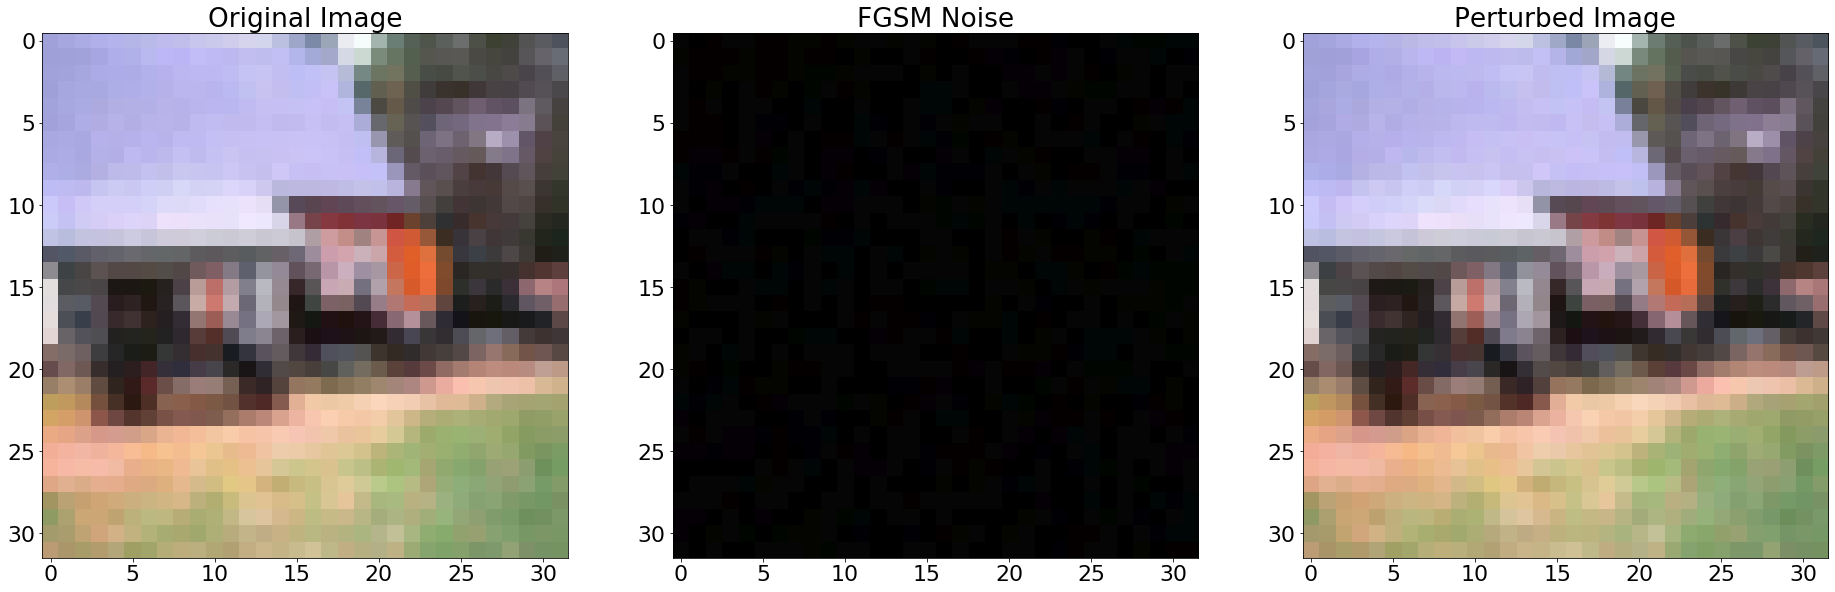

In [0]:
test_single_prediction(epsilon=0.02, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label is: 4 - deer
    
Before fgsm - Model prediction: 4 - deer with 99.94% Confidence
    
After fgsm - Model prediction: 2 - bird with 99.97% Confidence
    


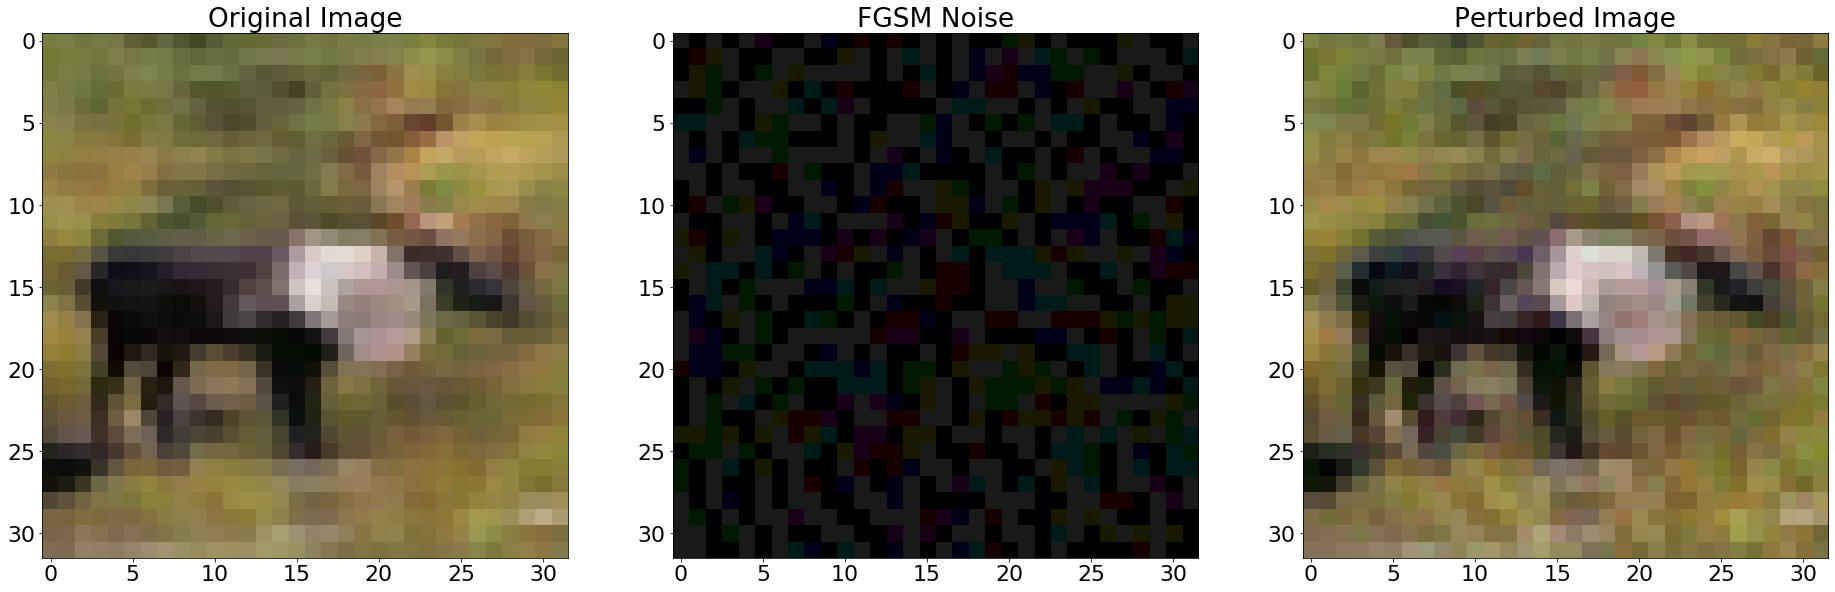

In [0]:
test_single_prediction(epsilon=0.1, model)

## Test model with fgsm attacks on entire testing dataset

In [0]:
def test_fgsm(model, device, test_loader1, epsilon):
    """given value of epsilon, determine prediction accuracy on test set
    without and without perturbation"""
    
    device = torch.device('cpu')
    model.to(device)
    model.eval()

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for images, labels in test_loader1:

        # Send the data and label to the device
        images, labels = images.to(device), labels.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        images.requires_grad = True

        # Forward pass the data through the model
        output = model(images)
        init_pred = output.max(
            1, keepdim=True)[1]  # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != labels.item():
            continue

        # Calculate the loss
        loss = criterion(output, labels)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        images_gradient = images.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm(images, epsilon, images_gradient)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(
            1, keepdim=True)[1]  # get the index of the max log-probability
        if final_pred.item() == labels.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append(
                    (init_pred.item(), final_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append(
                    (init_pred.item(), final_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader1))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(
        epsilon, correct, len(test_loader1), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [0]:
# List of epsilon values to test
epsilon = np.array((0,1,2,3,4,5,6,7,8,9,10))/255

In [0]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilon:
    acc, ex = test_fgsm(model, device, test_loader1, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 8416 / 10000 = 0.8416
Epsilon: 0.02	Test Accuracy = 6933 / 10000 = 0.6933


In [0]:
# visualization of epsilon vs test accuracy
plt.figure(figsize=(5, 5))
plt.plot(epsilon, accuracies, "*-")
plt.yticks(np.arange(0, 0.4, step=0.1))
plt.xticks(np.arange(0.05, 0.11, step=0.01))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

# Defending From Adversarial Attacks

## Set or load robust model

In [0]:
# Use this cell if training a new model
model_robust = Neural_Network()
device = cpu_or_gpu()
model.to(device)

In [0]:
# Use this cell if loading a saved model
model = Neural_Network()
device = cpu_or_gpu()
model.to(device)
model.load_state_dict(
    torch.load("finalmodelwithmaxdrop"))
               #Conv-NN-ReLU-88.5testaccuracy"))  # <------- Insert path of saved model as string here

model.eval()

In [0]:
# Summary of layers, output shape, parameters, and size
summary(model, input_size=(3, 32, 32))

## Robust training function

In [0]:
def train_robust():

    # Initial hyperparameters
    number_of_epochs = 100
    step_size = 0.01
    momentum_parameter = 0.9
    lambda1 = 0.001

    # L2 Regularization
    all_linear1_params = torch.cat(
        [x.view(-1) for x in model.fc1.parameters()])
    l2_regularization = lambda1 * torch.norm(all_linear1_params, 1)

    # Initialize optimiser
    optimiser = optim.SGD(model.parameters(),
                          lr=step_size,
                          momentum=momentum_parameter)

    # initialize lists for running counts of loss and accuracy
    running_loss = []
    running_val_loss = []
    running_loss_robust = []
    running_training_accuracy = []
    running_training_accuracy.append(0)
    running_val_accuracy = []
    running_val_accuracy.append(0)

    print("Log -- Step size: {}, Momentum: {}, batch_size = {}".format(
        step_size, momentum_parameter, train_batch_size))
    
    # loop for epochs
    for k in range(number_of_epochs):
        model.train()
        device = cpu_or_gpu()
        model.to(device)

        # initialize epoch loss and training accuracy
        epoch_loss = 0
        epoch_loss_robust = 0
        training_accuracy = 0


        # handle reducing step size at various iterations

        step_size = reduce_step_size(iteration_cutoff=10,
                                     old_step_size=step_size,
                                     new_step_size=0.001,
                                     epoch=k)

        optimiser = optim.SGD(model.parameters(),
                              lr=step_size,
                              momentum=momentum_parameter)

        # Main Training Loop
        for j, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            images.requires_grad = True
            
             # pass inputs through model one time to get regular model loss
            optimiser.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)+ (l2_regularization/len(images))
            loss.backward(retain_graph=True)
            
            # with probablity p=0.5, perturb images using random epsilon between 0 and 0.3
            probability = int(np.random.randint(1,10,1))
            if probability > 5:
              images = fgsm(images, int(np.random.randint(1,100,1))*0.03, images.grad.sign())
            
            # pass new inputs through model a second time to get robust model loss
            optimiser.zero_grad()
            outputs = model(images)
            loss_robust = criterion(outputs, labels) + (l2_regularization/len(images))
            loss_robust.backward(retain_graph=True)
            optimiser.step()

            epoch_loss += loss.item()
            epoch_loss_robust += loss_robust.item()
            training_accuracy += accuracy(outputs, labels)

        # Caclulate average loss and accuracy for each epoch
        running_loss.append(epoch_loss / len(train_loader))
        running_loss_robust.append(epoch_loss_robust / len(train_loader))
        running_training_accuracy.append(training_accuracy / len(train_loader))

        # Validation test once per epoch
        device = torch.device('cpu')
        model.eval()
        model.to(device)
        val_images, val_labels = iter(val_loader).next()
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = model(val_images) + (l2_regularization/len(val_images))
        val_loss = criterion(val_outputs, val_labels).item()

        # Store validation loss and accuracy
        running_val_loss.append(val_loss)
        val_accuracy = accuracy(val_outputs, val_labels)
        running_val_accuracy.append(val_accuracy)
        
        # Running log
        if k % 1 == 0:
            print(
                "Epoch {a}/{b} -> Tr. Loss (Original) = {c:.4f}, Tr. Loss (Robust) = {g:.4f} Val. Loss = {d:.4f}, Tr. Acc = {e:.2f}, Val. Acc = {f:.2f}"
                .format(a=k,
                        b=number_of_epochs,
                        c=running_loss[-1],
                        d=running_val_loss[-1],
                        e=running_training_accuracy[-1],
                        f=running_val_accuracy[-1]
                        g=running_loss_robust[-1]))
        
        # Break condition (validation loss is rising)
        """if len(running_val_loss) > 30 and running_val_loss[-1] - running_val_loss[-30] > 0:
            break"""

    print("Final Epoch {} -> Loss = {}".format(k, running_loss_robust[-1]))

    return running_loss, running_loss_robust, running_val_loss, running_training_accuracy, running_val_accuracy

In [0]:
running_loss1, running_loss_robust, running_val_loss1, running_training_accuracy1, running_val_accuracy1 = train_robust()

Log -- Step size: 0.01, Momentum: 0.9, batch_size = 32
Epoch 0/100 -> Tr. Loss = 1.8173, Val. Loss = 1.4291, Tr. Acc = 32.00, Val. Acc = 46.02
Epoch 1/100 -> Tr. Loss = 1.3706, Val. Loss = 1.1677, Tr. Acc = 50.36, Val. Acc = 58.26
Epoch 2/100 -> Tr. Loss = 1.1548, Val. Loss = 0.9418, Tr. Acc = 58.74, Val. Acc = 66.88
Epoch 3/100 -> Tr. Loss = 1.0452, Val. Loss = 0.8227, Tr. Acc = 62.91, Val. Acc = 71.02
Epoch 4/100 -> Tr. Loss = 0.9597, Val. Loss = 0.7760, Tr. Acc = 66.21, Val. Acc = 73.40
Epoch 5/100 -> Tr. Loss = 0.8935, Val. Loss = 0.7362, Tr. Acc = 68.66, Val. Acc = 74.42
Epoch 6/100 -> Tr. Loss = 0.8437, Val. Loss = 0.7332, Tr. Acc = 70.38, Val. Acc = 73.60
Epoch 7/100 -> Tr. Loss = 0.8119, Val. Loss = 0.7099, Tr. Acc = 71.53, Val. Acc = 74.48
Epoch 8/100 -> Tr. Loss = 0.7777, Val. Loss = 0.6595, Tr. Acc = 72.63, Val. Acc = 77.36
Epoch 9/100 -> Tr. Loss = 0.7550, Val. Loss = 0.6434, Tr. Acc = 73.47, Val. Acc = 76.92
Log -- Decreased Step size from 0.01 to 0.001
Epoch 10/100 -> Tr.

KeyboardInterrupt: ignored

In [0]:
test_on_testing_data()

In [0]:
# For saving neural network parameters
torch.save(model_robust.state_dict(), 
           "ourmodel96percentaccuracy")  # <----- make sure to update the path if saving new model

In [0]:
accuracies_robust = []
examples_robust = []

# Run test for each epsilon
for eps in epsilon:
    acc_robust, ex_robust = test_fgsm(model_robust, device, test_loader1, eps)
    accuracies_robust.append(acc)
    examples_robust.append(ex)